# Base models

In this script I run the following models: 
- RandomForest, XGBoost, CatBoost

I use three possible data sets based on the script `feature-selection.ipynb`. 

We evaluate these base models based on the dataset with selected features (see script `feature-selection.ipynb`). Due to the size of the data set we do not run cross-validation. 


In [12]:
# libraries
import pandas as pd
import numpy as np
from sklearn.model_selection import cross_validate
from sklearn.metrics import make_scorer, mean_absolute_error, mean_squared_error, r2_score

# model estimators
import catboost
from catboost import CatBoostRegressor
from sklearn.ensemble import RandomForestRegressor
from xgboost import XGBRegressor

# visualization
import matplotlib.pyplot as plt
from joblib import dump

# for wrapper around XGBoostRegressor
from sklearn.base import BaseEstimator, RegressorMixin


In [13]:
# User functions
# Prepare markdown table
def scores_to_markdown(scores):
    # Create table header
    header = '| Model | MAE | MSE | RMSE | R2 |\n'
    header += '|-------|-----|-----|------|-----|\n'
    
    # Create table rows
    table_rows = ''
    for model_name, metrics in scores.items():
        table_rows += f'| {model_name} | {metrics['MAE']:.4f} | {metrics['MSE']:.4f} | {metrics['RMSE']:.4f} | {metrics['R2']:.4f} |\n'
    
    return header + table_rows

# Fixed issues with __sklearn_tags__
class SklearnXGBRegressor(BaseEstimator, RegressorMixin):
    def __init__(self, **kwargs):
        self.model = XGBRegressor(**kwargs)
    
    def fit(self, X, y):
        self.model.fit(X, y)
        return self
    
    def predict(self, X):
        return self.model.predict(X)

## No selection data set

In [14]:
train = pd.read_csv('data/processed/train_eng.csv', index_col=0)

X_train = train.drop(columns=['severity_score'], axis=1)
y_train = train['severity_score']

In [15]:
# Define models
models = {
    'Random Forest': RandomForestRegressor(n_estimators=100, random_state=42),
    'XGBoost': SklearnXGBRegressor(n_estimators=100, learning_rate=0.1, random_state=42),
    'CatBoost': CatBoostRegressor(iterations=1000, learning_rate=0.05, depth=10, verbose=200)
}

names = ['Mean Prediction', 'Random Forest', 'XGBoost', 'CatBoost']

# Dictionary to store scores
metrics = ['MAE', 'MSE', 'RMSE', 'R2']
scores = {model_name: {metric: [] for metric in metrics} for model_name in names}

scoring = {
    'MAE': make_scorer(mean_absolute_error, greater_is_better=False),
    'MSE': make_scorer(mean_squared_error, greater_is_better=False),
    'R2': 'r2'
}

# Mean prediction as baseline model
mean_value = np.mean(y_train)

mean_predictions = np.full_like(y_train, mean_value)

scores['Mean Prediction']['MAE'] = mean_absolute_error(y_train, mean_predictions)
scores['Mean Prediction']['MSE']= mean_squared_error(y_train, mean_predictions)
scores['Mean Prediction']['RMSE'] = np.sqrt(mean_squared_error(y_train, mean_predictions))
scores['Mean Prediction']['R2'] = r2_score(y_train, mean_predictions)

# Perform cross-validation
for model_name, model in models.items():
    print(f'Evaluating {model_name}...')
    
    # Cross-validation for all metrics
    cv_results = cross_validate(model, X_train, y_train, cv=5, scoring=scoring, return_train_score=False)
    
    # Store metrics
    scores[model_name]['MAE'] = -np.mean(cv_results['test_MAE'])  # Negate because scoring uses greater_is_better=False
    scores[model_name]['MSE'] = -np.mean(cv_results['test_MSE'])  # Negate for the same reason
    scores[model_name]['RMSE'] = np.sqrt(scores[model_name]['MSE'])
    scores[model_name]['R2'] = np.mean(cv_results['test_R2'])

# Print scores
for model_name, metrics in scores.items():
    print(f'\n{model_name}:')
    for metric, value in metrics.items():
        print(f'{metric}: {value:.4f}')

Evaluating Random Forest...
Evaluating XGBoost...
Evaluating CatBoost...
0:	learn: 1.8320276	total: 64.9ms	remaining: 1m 4s
200:	learn: 1.4384021	total: 1.49s	remaining: 5.91s
400:	learn: 1.3671105	total: 2.81s	remaining: 4.2s
600:	learn: 1.3080562	total: 4.23s	remaining: 2.81s
800:	learn: 1.2545750	total: 5.71s	remaining: 1.42s
999:	learn: 1.2064444	total: 7.07s	remaining: 0us
0:	learn: 1.8302563	total: 6.5ms	remaining: 6.5s
200:	learn: 1.4341420	total: 1.39s	remaining: 5.52s
400:	learn: 1.3649367	total: 2.79s	remaining: 4.17s
600:	learn: 1.3040692	total: 4.23s	remaining: 2.81s
800:	learn: 1.2510184	total: 5.61s	remaining: 1.39s
999:	learn: 1.2048582	total: 7.02s	remaining: 0us
0:	learn: 1.8253109	total: 7.1ms	remaining: 7.09s
200:	learn: 1.4358695	total: 1.46s	remaining: 5.8s
400:	learn: 1.3654914	total: 2.91s	remaining: 4.35s
600:	learn: 1.3054137	total: 4.36s	remaining: 2.89s
800:	learn: 1.2532554	total: 5.82s	remaining: 1.45s
999:	learn: 1.2086158	total: 7.32s	remaining: 0us
0:	le

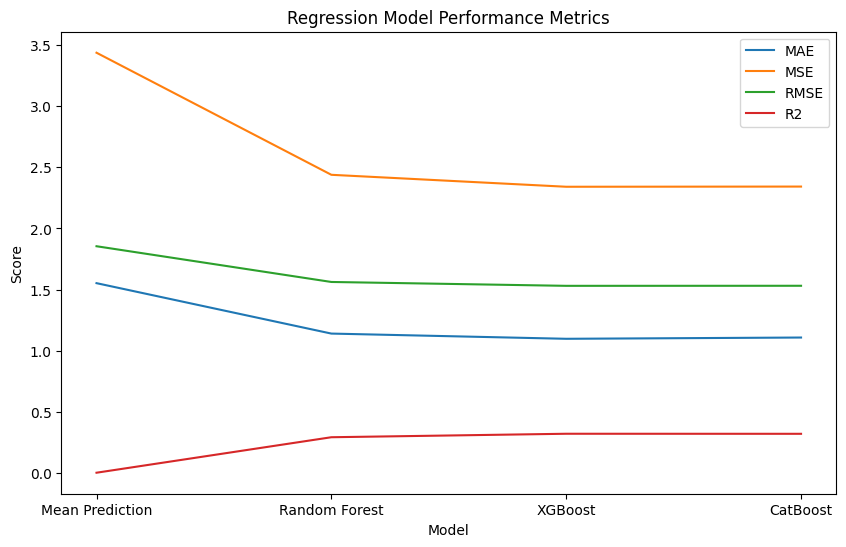

<Figure size 640x480 with 0 Axes>

In [37]:
# Prepare data for plotting
plot_data = {metric: [scores[model][metric] for model in names] for metric in metrics}

# Plot
plt.figure(figsize=(10, 6))
for metric, values in plot_data.items():
    plt.plot(names, values, label=metric)

plt.xlabel('Model')
plt.ylabel('Score')
plt.title('Regression Model Performance Metrics')
plt.legend()
plt.show()

plt.savefig('output/all-performance.png', dpi=300)

In [38]:
# Generate the markdown table and save to file
markdown_table = scores_to_markdown(scores)
with open('output/model_scores.md', 'w') as f:
    f.write(markdown_table)

In [39]:
import joblib

# Save models
for model_name, model in models.items():
    joblib.dump(model, f'output/{model_name}_model.pkl')

## K-Best Selection

In [19]:
train = pd.read_csv('data/processed/train_ksel.csv', index_col=0)

X_train = train.drop(columns=['severity_score'], axis=1)
y_train = train['severity_score']

In [20]:
# Define models
models_ksel = {
    'Random Forest': RandomForestRegressor(n_estimators=100, random_state=42),
    'XGBoost': SklearnXGBRegressor(n_estimators=100, learning_rate=0.1, random_state=42),
    'CatBoost': CatBoostRegressor(iterations=1000, learning_rate=0.05, depth=10, verbose=200)
}

# Dictionary to store scores
metrics_ksel = ['MAE', 'MSE', 'RMSE', 'R2']
scores_ksel = {model_name: {metric: [] for metric in metrics_ksel} for model_name in names}

scoring = {
    'MAE': make_scorer(mean_absolute_error, greater_is_better=False),
    'MSE': make_scorer(mean_squared_error, greater_is_better=False),
    'R2': 'r2'
}

# Mean prediction as baseline model
mean_value = np.mean(y_train)

mean_predictions = np.full_like(y_train, mean_value)

scores_ksel['Mean Prediction']['MAE'] = mean_absolute_error(y_train, mean_predictions)
scores_ksel['Mean Prediction']['MSE']= mean_squared_error(y_train, mean_predictions)
scores_ksel['Mean Prediction']['RMSE'] = np.sqrt(mean_squared_error(y_train, mean_predictions))
scores_ksel['Mean Prediction']['R2'] = r2_score(y_train, mean_predictions)

# Perform cross-validation
for model_name, model in models_ksel.items():
    print(f'Evaluating {model_name}...')
    
    # Cross-validation for all metrics
    cv_results = cross_validate(model, X_train, y_train, cv=5, scoring=scoring, return_train_score=False)
    
    # Store metrics
    scores_ksel[model_name]['MAE'] = -np.mean(cv_results['test_MAE'])  # Negate because scoring uses greater_is_better=False
    scores_ksel[model_name]['MSE'] = -np.mean(cv_results['test_MSE'])  # Negate for the same reason
    scores_ksel[model_name]['RMSE'] = np.sqrt(scores[model_name]['MSE'])
    scores_ksel[model_name]['R2'] = np.mean(cv_results['test_R2'])

# Print scores
for model_name, metrics in scores_ksel.items():
    print(f'\n{model_name}:')
    for metric, value in metrics.items():
        print(f'{metric}: {value:.4f}')

Evaluating Random Forest...
Evaluating XGBoost...
Evaluating CatBoost...
0:	learn: 1.8319381	total: 6ms	remaining: 5.99s
200:	learn: 1.4799273	total: 1.22s	remaining: 4.84s
400:	learn: 1.4360309	total: 2.48s	remaining: 3.71s
600:	learn: 1.4044040	total: 3.72s	remaining: 2.47s
800:	learn: 1.3779126	total: 4.95s	remaining: 1.23s
999:	learn: 1.3549771	total: 6.2s	remaining: 0us
0:	learn: 1.8297915	total: 6.17ms	remaining: 6.16s
200:	learn: 1.4766601	total: 1.22s	remaining: 4.87s
400:	learn: 1.4333719	total: 2.48s	remaining: 3.71s
600:	learn: 1.4011531	total: 3.72s	remaining: 2.47s
800:	learn: 1.3750887	total: 5.03s	remaining: 1.25s
999:	learn: 1.3531334	total: 6.26s	remaining: 0us
0:	learn: 1.8249402	total: 6.51ms	remaining: 6.5s
200:	learn: 1.4759606	total: 1.36s	remaining: 5.39s
400:	learn: 1.4329679	total: 2.64s	remaining: 3.94s
600:	learn: 1.4020320	total: 3.89s	remaining: 2.58s
800:	learn: 1.3758767	total: 5.14s	remaining: 1.28s
999:	learn: 1.3533204	total: 6.37s	remaining: 0us
0:	le

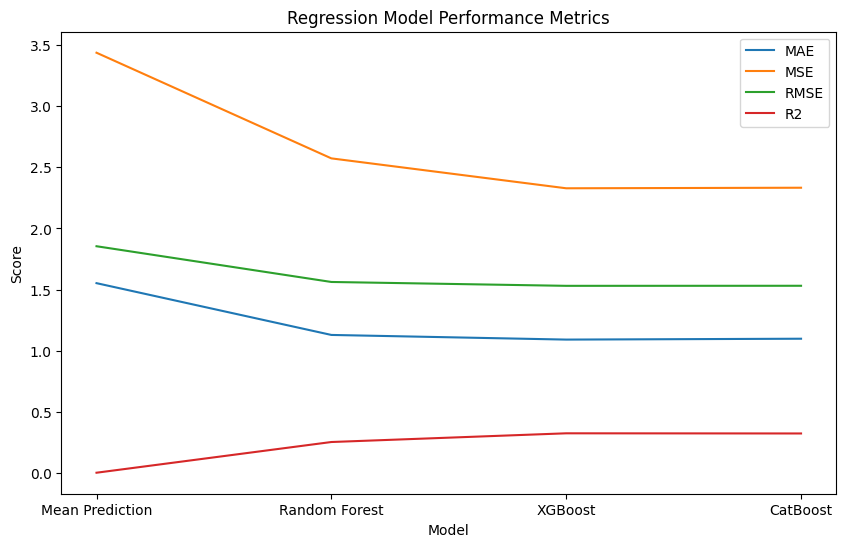

<Figure size 640x480 with 0 Axes>

In [33]:
# Prepare data for plotting
plot_data = {metric: [scores_ksel[model][metric] for model in names] for metric in metrics_ksel}

# Plot
plt.figure(figsize=(10, 6))
for metric, values in plot_data.items():
    plt.plot(names, values, label=metric)

plt.xlabel('Model')
plt.ylabel('Score')
plt.title('Regression Model Performance Metrics')
plt.legend()
plt.show()

plt.savefig('output/ksel-performance.png', dpi=300)

In [34]:
# Generate the markdown table and save to file
markdown_table = scores_to_markdown(scores)
with open('output/model_scores_ksel.md', 'w') as f:
    f.write(markdown_table)

In [35]:
# Save models
for model_name, model in models_ksel.items():
    joblib.dump(model, f'output/{model_name}_model_ksel.pkl')

## PCA

In [24]:
train = pd.read_csv('data/processed/train_pca.csv', index_col=0)

X_train = train.drop(columns=['severity_score'], axis=1)
y_train = train['severity_score']

In [25]:
# Define models
models_pca = {
    'Random Forest': RandomForestRegressor(n_estimators=100, random_state=42),
    'XGBoost': SklearnXGBRegressor(n_estimators=100, learning_rate=0.1, random_state=42),
    'CatBoost': CatBoostRegressor(iterations=1000, learning_rate=0.05, depth=10, verbose=200)
}

# Dictionary to store scores
metrics_pca = ['MAE', 'MSE', 'RMSE', 'R2']
scores_pca = {model_name: {metric: [] for metric in metrics_pca} for model_name in names}

scoring = {
    'MAE': make_scorer(mean_absolute_error, greater_is_better=False),
    'MSE': make_scorer(mean_squared_error, greater_is_better=False),
    'R2': 'r2'
}

# Mean prediction as baseline model
mean_value = np.mean(y_train)

mean_predictions = np.full_like(y_train, mean_value)

scores_pca['Mean Prediction']['MAE'] = mean_absolute_error(y_train, mean_predictions)
scores_pca['Mean Prediction']['MSE']= mean_squared_error(y_train, mean_predictions)
scores_pca['Mean Prediction']['RMSE'] = np.sqrt(mean_squared_error(y_train, mean_predictions))
scores_pca['Mean Prediction']['R2'] = r2_score(y_train, mean_predictions)

# Perform cross-validation
for model_name, model in models_pca.items():
    print(f'Evaluating {model_name}...')
    
    # Cross-validation for all metrics
    cv_results = cross_validate(model, X_train, y_train, cv=5, scoring=scoring, return_train_score=False)
    
    # Store metrics
    scores_pca[model_name]['MAE'] = -np.mean(cv_results['test_MAE'])  # Negate because scoring uses greater_is_better=False
    scores_pca[model_name]['MSE'] = -np.mean(cv_results['test_MSE'])  # Negate for the same reason
    scores_pca[model_name]['RMSE'] = np.sqrt(scores[model_name]['MSE'])
    scores_pca[model_name]['R2'] = np.mean(cv_results['test_R2'])
    
# Print scores
for model_name, metrics in scores_pca.items():
    print(f'\n{model_name}:')
    for metric, value in metrics.items():
        print(f'{metric}: {value:.4f}')

Evaluating Random Forest...
Evaluating XGBoost...
Evaluating CatBoost...
0:	learn: 1.8356708	total: 10.2ms	remaining: 10.2s
200:	learn: 1.4953020	total: 2.11s	remaining: 8.39s
400:	learn: 1.4184000	total: 4.18s	remaining: 6.24s
600:	learn: 1.3522185	total: 6.32s	remaining: 4.19s
800:	learn: 1.2954512	total: 8.48s	remaining: 2.11s
999:	learn: 1.2426311	total: 10.7s	remaining: 0us
0:	learn: 1.8339195	total: 12.4ms	remaining: 12.4s
200:	learn: 1.4931276	total: 2.29s	remaining: 9.08s
400:	learn: 1.4172470	total: 4.51s	remaining: 6.73s
600:	learn: 1.3507653	total: 6.75s	remaining: 4.48s
800:	learn: 1.2913180	total: 9.04s	remaining: 2.25s
999:	learn: 1.2379618	total: 11.3s	remaining: 0us
0:	learn: 1.8290627	total: 12.1ms	remaining: 12.1s
200:	learn: 1.4925562	total: 2.39s	remaining: 9.51s
400:	learn: 1.4161966	total: 4.89s	remaining: 7.31s
600:	learn: 1.3489567	total: 7.4s	remaining: 4.92s
800:	learn: 1.2915246	total: 10.3s	remaining: 2.55s
999:	learn: 1.2413359	total: 13.2s	remaining: 0us
0

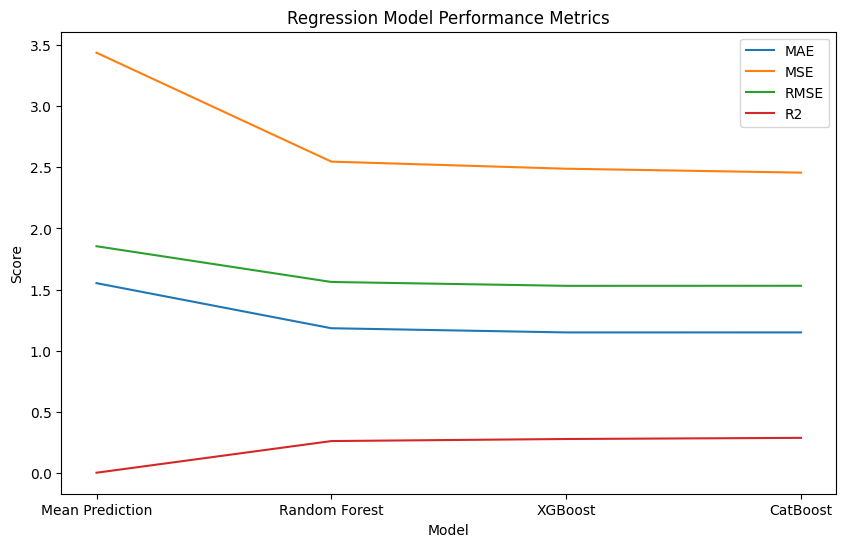

<Figure size 640x480 with 0 Axes>

In [30]:
# Prepare data for plotting
plot_data = {metric: [scores_pca[model][metric] for model in names] for metric in metrics_pca}

# Plot
plt.figure(figsize=(10, 6))
for metric, values in plot_data.items():
    plt.plot(names, values, label=metric)

plt.xlabel('Model')
plt.ylabel('Score')
plt.title('Regression Model Performance Metrics')
plt.legend()
plt.show()

plt.savefig('output/pca-performance.png', dpi=300)

In [31]:
# Generate the markdown table and save to file
markdown_table = scores_to_markdown(scores)
with open('output/model_scores_pca.md', 'w') as f:
    f.write(markdown_table)

In [32]:
# Save models
for model_name, model in models_pca.items():
    joblib.dump(model, f'output/{model_name}_model_pca.pkl')